# Image classification using AWS Sagemaker: dog breed dataset

This project is oriented  to use AWS Sagemaker for making a pretrained model that can perform image classification on provided dog-breed dataset by using the Sagemaker profiling, debugger, hyperparameter tuning and other good ML engineering practices.

In [9]:
# Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

In [2]:
# Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import sagemaker
import boto3

In [35]:
# use default S3 bucket
bucket = sagemaker_session.default_bucket()

import os
# Upload data to S3 bucket.
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/

## Dataset

In this project I have used the dog breed dataset. This dataset contains images of several dog breeds. The "dogImages" dataset contains three sections for data training, testing and validation. Each group has all the dog breeds and their respective images in each folder.

In [4]:
 #session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
region = "us-east-1"

In [2]:
# Fetch and upload the data to AWS S3

# Command to download and unzip data
!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip

--2022-07-25 11:59:30--  https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.224
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.224|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1132023110 (1.1G) [application/zip]
Saving to: ‘dogImages.zip.1’

dogImages.zip.1     100%[===================>]   1.05G  44.7MB/s    in 27s     

2022-07-25 11:59:58 (40.0 MB/s) - ‘dogImages.zip.1’ saved [1132023110/1132023110]

Archive:  dogImages.zip
replace dogImages/test/001.Affenpinscher/Affenpinscher_00003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [13]:
# use default S3 bucket
bucket = sagemaker_session.default_bucket()

import os
# Upload data to S3 bucket.
os.environ["DEFAULT_S3_BUCKET"] = bucket
!aws s3 sync ./dogImages s3://${DEFAULT_S3_BUCKET}/dogImages/

## Hyperparameter Tuning
This is the part finetuning of pretrained model with hyperparameter tuning. We define hyperparameters space hard as a value or in ranges.

Its need to use the `hpo.py` script to perform hyperparameter tuning.

In [14]:
from sagemaker.tuner import (
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256])
}
objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [23]:
# Creating estimators for Hyperparameter tuning jobs

from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    entry_point="hpo.py",
    base_job_name = 'hpo_tuning_dog_breed',
    role=role,
    py_version='py3',
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.m5.xlarge"
    )


tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=4,
    max_parallel_jobs=2,
    objective_type=objective_type,
)

In [24]:
# assigning S3 paths for the training job
s3_data = "s3://{}/{}/".format(bucket, "dogImages")
s3_output_dir = "s3://{}/{}/".format(bucket, "output")
s3_model_dir = "s3://{}/{}/".format(bucket, "model")

os.environ['SM_CHANNEL_TRAIN']= s3_data
os.environ['SM_MODEL_DIR']= s3_model_dir
os.environ['SM_OUTPUT_DATA_DIR']= s3_output_dir

In [25]:
# Fit the HP Tuner with input data channel

tuner.fit({'train' : s3_data},wait=True) 

.............................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [26]:
# Get the best estimators and the best HPs

best_estimator = tuner.best_estimator()

# Getting the hyperparameters of the best trained model
best_estimator.hyperparameters()


2022-07-25 14:00:12 Starting - Preparing the instances for training
2022-07-25 14:00:12 Downloading - Downloading input data
2022-07-25 14:00:12 Training - Training image download completed. Training in progress.
2022-07-25 14:00:12 Uploading - Uploading generated training model
2022-07-25 14:00:12 Completed - Training job completed


{'_tuning_objective_metric': '"Test Loss"',
 'batch_size': '"32"',
 'lr': '0.0019324808678371295',
 'sagemaker_container_log_level': '20',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"hpo_tuning_dog_breed-2022-07-25-13-23-00-337"',
 'sagemaker_program': '"hpo.py"',
 'sagemaker_region': '"us-east-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-us-east-1-318652348441/hpo_tuning_dog_breed-2022-07-25-13-23-00-337/source/sourcedir.tar.gz"'}

## Model Profiling and Debugging
Using the best hyperparameters, create and finetune a new model

We will need to use the `train_model.py` script to perform model profiling and debugging.

In [27]:
# Setting up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs, CollectionConfig
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]
collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)
debugger_config=DebuggerHookConfig(
    collection_configs=collection_configs
)

In [31]:
# Create and fit an estimator with best parameters

hyperparameters = {"batch_size": "32", "lr": "0.0019324808678371295"} # Training with best parameters
estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.m5.xlarge",
    entry_point="train_model.py",
    framework_version="1.4.0",
    py_version="py3",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config, # include the profiler hook
    debugger_hook_config=debugger_config, # include the debugger hook
    rules=rules
)

estimator.fit({'train' : s3_data},wait=True)

2022-07-25 14:17:41 Starting - Starting the training job...
2022-07-25 14:18:02 Starting - Preparing the instances for trainingVanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
ProfilerReport: InProgress
.........
2022-07-25 14:19:37 Downloading - Downloading input data...........bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2022-07-25 14:21:20,204 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2022-07-25 14:21:20,208 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2022-07-25 14:21:20,219 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2022-07-25 14:21:20,223 sagemaker_pytorch_container.training INFO     Invoking user training script.
2022-07-25 14:21:20,751 sagemaker-containers INFO     Module default_user_module_name does not provide a setup.py. 

In [32]:
# Plot a debugging output.

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor('CrossEntropyLoss_output_0').steps(mode=ModeKeys.EVAL)))

Training jobname: pytorch-training-2022-07-25-14-17-41-417
Region: us-east-1
[2022-07-25 14:35:23.872 ip-172-16-42-200:18470 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-07-25 14:35:23.911 ip-172-16-42-200:18470 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-318652348441/pytorch-training-2022-07-25-14-17-41-417/debug-output


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


[2022-07-25 14:35:27.954 ip-172-16-42-200:18470 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2022-07-25 14:35:28.973 ip-172-16-42-200:18470 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'gradient/ResNet_fc.4.bias', 'gradient/ResNet_fc.4.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.1.relu_input_0', 'layer3.1.relu_input_1', 'layer3.2.relu_input_0', 'layer3.2.relu_input_1', 'layer3.3.relu_input_0', 'layer3.3.relu_input_1', 'layer3.4.relu_input_0', 'layer

In [33]:
tensor_name = "CrossEntropyLoss_output_0"

In [34]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [35]:
get_data(trial, tensor_name, mode=ModeKeys.TRAIN)

([0,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  180,
  190,
  200],
 [array(4.8523593, dtype=float32),
  array(4.9130363, dtype=float32),
  array(4.747438, dtype=float32),
  array(4.5529194, dtype=float32),
  array(4.3255014, dtype=float32),
  array(4.442256, dtype=float32),
  array(3.5650032, dtype=float32),
  array(3.6002781, dtype=float32),
  array(3.488827, dtype=float32),
  array(2.8672538, dtype=float32),
  array(2.7324781, dtype=float32),
  array(2.2202325, dtype=float32),
  array(2.8599107, dtype=float32),
  array(2.2631705, dtype=float32),
  array(2.102446, dtype=float32),
  array(1.6598667, dtype=float32),
  array(1.7798289, dtype=float32),
  array(2.0718594, dtype=float32),
  array(2.1262221, dtype=float32),
  array(2.1733737, dtype=float32),
  array(1.6982516, dtype=float32)])

In [36]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


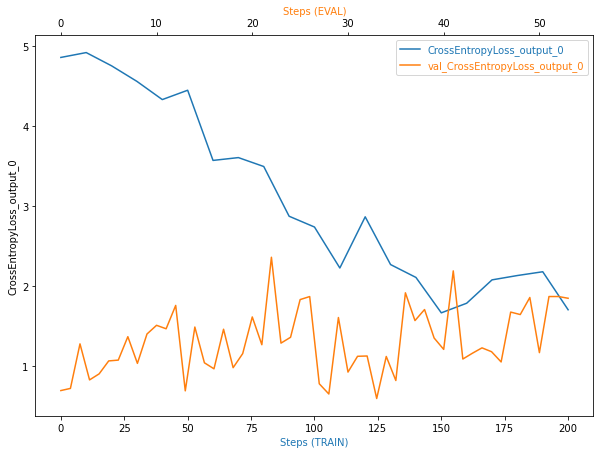

In [37]:
plot_tensor(trial, "CrossEntropyLoss_output_0") #Plotting the loss

In [38]:
# Display the profiler output
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-318652348441/pytorch-training-2022-07-25-14-17-41-417/rule-output


In [39]:
! aws s3 ls {rule_output_path} --recursive

2022-07-25 14:34:33     329704 pytorch-training-2022-07-25-14-17-41-417/rule-output/ProfilerReport/profiler-output/profiler-report.html
2022-07-25 14:34:33     171064 pytorch-training-2022-07-25-14-17-41-417/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2022-07-25 14:34:29        192 pytorch-training-2022-07-25-14-17-41-417/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2022-07-25 14:34:29        200 pytorch-training-2022-07-25-14-17-41-417/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2022-07-25 14:34:29        126 pytorch-training-2022-07-25-14-17-41-417/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2022-07-25 14:34:29        127 pytorch-training-2022-07-25-14-17-41-417/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2022-07-25 14:34:29        199 pytorch-training-2022-07-25-14-17-41-417/rule-output/ProfilerReport/profiler-output/profiler-re

In [40]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-318652348441/pytorch-training-2022-07-25-14-17-41-417/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-318652348441/pytorch-training-2022-07-25-14-17-41-417/rule-output/ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json to ProfilerReport/profiler-output/profiler-reports/MaxInitializationTime.json
download: s3://sagemaker-us-east-1-318652348441/pytorch-training-2022-07-25-14-17-41-417/rule-output/ProfilerReport/profiler-output/profiler-report.html to ProfilerReport/profiler-output/profiler-report.html
download: s3://sagemaker-us-east-1-318652348441/pytorch-training-2022-07-25-14-17-41-417/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-318652348441/pytorch-training-2022-

In [41]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [42]:

import IPython
# output the profiler report
IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

When the model was trained for the first time, no debugging or profiling was done on it. So, it was difficult to know if the training was done well. Inorder to acheive this, we performed debugging and profiling.

In [ ]:
# TODO: Display the profiler output

In [5]:
#estimator = sagemaker.estimator.Estimator.attach('pytorch-training-2022-07-25-14-17-41-417')


2022-07-25 14:35:04 Starting - Preparing the instances for training
2022-07-25 14:35:04 Downloading - Downloading input data
2022-07-25 14:35:04 Training - Training image download completed. Training in progress.
2022-07-25 14:35:04 Uploading - Uploading generated training model
2022-07-25 14:35:04 Completed - Training job completed


## Model Deploying

In [9]:
model_location=estimator.model_data

In [6]:
import sagemaker
import boto3
from sagemaker.tuner import CategoricalParameter, ContinuousParameter, HyperparameterTuner
from sagemaker.pytorch import PyTorch
from sagemaker import get_execution_role
from sagemaker.debugger import Rule, DebuggerHookConfig, TensorBoardOutputConfig, CollectionConfig, ProfilerRule, rule_configs
from sagemaker.debugger import ProfilerConfig, FrameworkProfile

from sagemaker.pytorch import PyTorchModel
from sagemaker.predictor import Predictor

In [7]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()


class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer,
        )

In [29]:
pytorch_model = PyTorchModel(model_data=model_location, role=role, entry_point='endpoint.py',py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor) 

In [30]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.xlarge')

-----!

In [31]:
!ls

CODEOWNERS     dogImages.zip.1	hpo.py		README.md
dogImages      endpoint.py	LICENSE.txt	train_and_deploy.ipynb
dogImages.zip  hpo 1.py		ProfilerReport	train_model.py


In [32]:
with open("dogImages/test/004.Akita/Akita_00244.jpg", "rb") as f:
    payload = f.read()
        
type(payload)

bytes

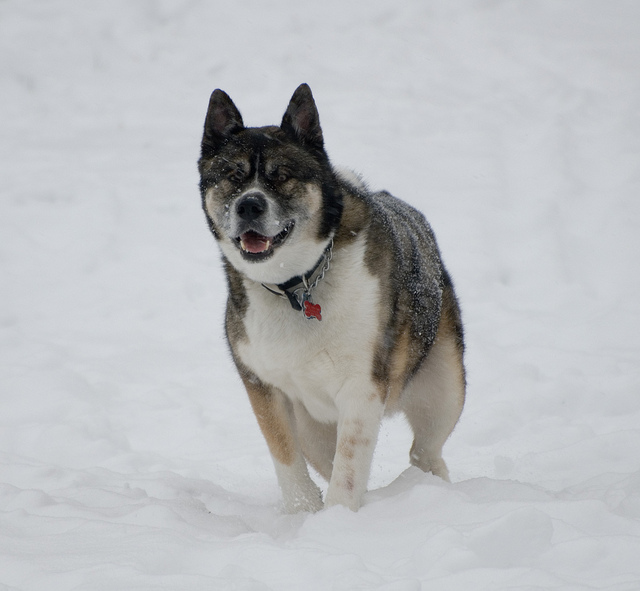

In [33]:
from PIL import Image
import io
Image.open(io.BytesIO(payload))

In [34]:
response=predictor.predict(payload, initial_args={"ContentType": "image/jpeg"})
response

[[-13.24834156036377,
  -8.252618789672852,
  -9.395301818847656,
  -0.32637500762939453,
  0.35709601640701294,
  -8.787214279174805,
  -6.525308609008789,
  -1.2450007200241089,
  -17.887292861938477,
  -4.425269603729248,
  -0.2825898230075836,
  -1.5286165475845337,
  -7.980578899383545,
  -2.409106731414795,
  -10.353760719299316,
  -9.863566398620605,
  -11.306462287902832,
  -3.5672032833099365,
  -14.876635551452637,
  -0.10850565880537033,
  -7.072326183319092,
  -4.901467800140381,
  -6.618189811706543,
  -11.738826751708984,
  -12.923336029052734,
  -13.198432922363281,
  -10.730413436889648,
  -9.672066688537598,
  -4.8525261878967285,
  -8.841296195983887,
  -6.6258440017700195,
  -3.7851223945617676,
  -12.596087455749512,
  -9.179670333862305,
  -14.70537281036377,
  -11.057284355163574,
  -11.85245418548584,
  -10.62484359741211,
  -5.501718997955322,
  -6.557322978973389,
  -6.805445194244385,
  -10.337472915649414,
  -2.081045150756836,
  -8.158733367919922,
  1.99229

In [77]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()